<a href="https://colab.research.google.com/github/Hugo-Andres/Data-Science/blob/main/Detecci%C3%B3n_de_Fraude_con_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos las bibliotecas necesarias para nuestro análisis, visualización y predicción.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import files
#from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
#Fuente: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

In [5]:
files.upload()

Saving Fraud.csv to Fraud.csv


In [38]:
df= pd.read_csv("Fraud.csv")

In [39]:
warnings.filterwarnings("ignore")

Vamos a conocer como se conforma nuestro Dataset.

In [40]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df.shape

(6362620, 11)

Contamos 6362620 filas y 11 columnas.

In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Podemos ver que no tenemos valores nulos en nuestros datos.

In [ ]:
df.duplicated().sum()

No existen valores duplicados

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


isFraud
0    6354407
1       8213
dtype: int64


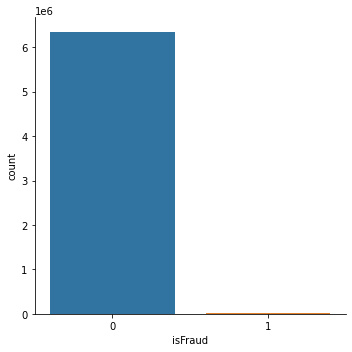

In [10]:
#Observamos la distribución de la columna 'sFraud'
sns.catplot('isFraud', data=df, kind='count');
print(df.groupby('isFraud').size());

Como podemos ver, tenemos la clase 'isFraud' desbalanceada.
Con 6354407 operaciones 'honestas' y solo 8213 operaciones 'fraudulentas'

In [ ]:
#Veremos cuantos 'fraudes' acertó el algoritmo previo ('isFlaggedFraud')
print('1 = Aciertos'
      '\n0 = No Aciertos ')
df[['isFlaggedFraud', 'isFraud']].groupby(['isFlaggedFraud'], as_index=False).sum().sort_values(by='isFraud', ascending=False)

1 = Aciertos
0 = No Aciertos 


,isFlaggedFraud,isFraud
0,0,8197
1,1,16


Nuestro dataset tieene una columna predictora de fraude, la cual no es para nada efectiva ya que solo tiene 16 aciertos de 8213 casos de fraude reales.

Text(0.5, 1.0, 'Matriz de Correlación de variables')

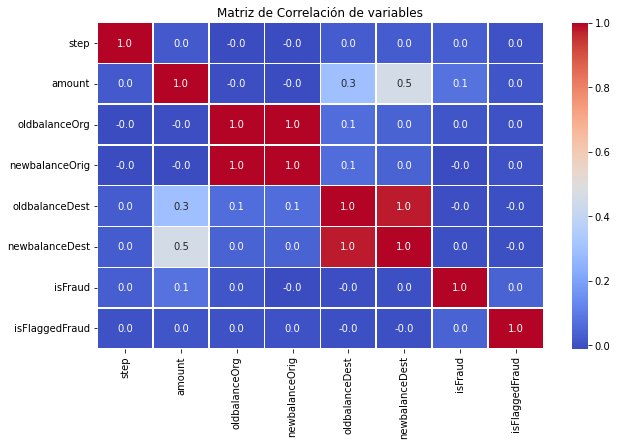

In [ ]:
#Vamos a ver la correlación de las variables
plt.rcParams['figure.figsize']=(10,6)
sns.heatmap(df.corr(), cmap= 'coolwarm', linewidth= .5, fmt= '.1f', annot=True)
plt.title('Matriz de Correlación de variables')

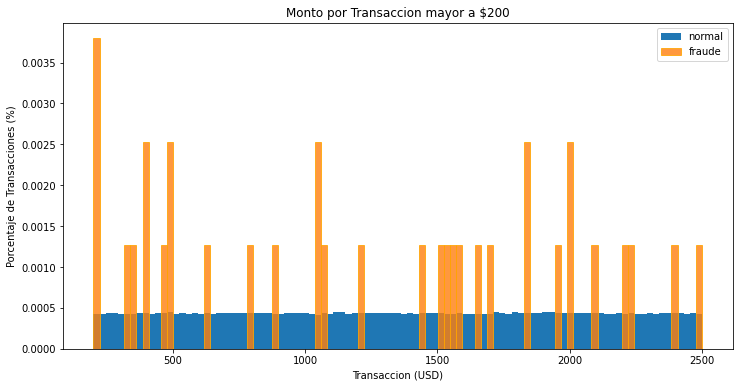

In [14]:
normal_df = df[df.isFraud == 0] #normal
fraude_df = df[df.isFraud == 1] #fraude
plt.figure(figsize=(12,6))
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.amount, bins, alpha=1, density=True, label='normal')
plt.hist(fraude_df.amount, bins, alpha=0.8, edgecolor = 'orange', density=True, label='fraude')
plt.legend(loc='upper right')
plt.title('Monto por Transaccion mayor a $200')
plt.xlabel('Transaccion (USD)')
plt.ylabel('Porcentaje de Transacciones (%)')
plt.show()

Podemos ver una gran cantidad de transacciones fraudulentas de poco monto (un poco mayor de 200USD), 
Y luego tenemos también gran porcentaje de transacciones fraudulentas cerca de 500USD, 1000USD y 2000USD.



Ahora, las variables categóricas no aparecen en la Matriz de Correlación, entonces las analizaremos y si es que debemos, las pasaremos a variables numéricas.

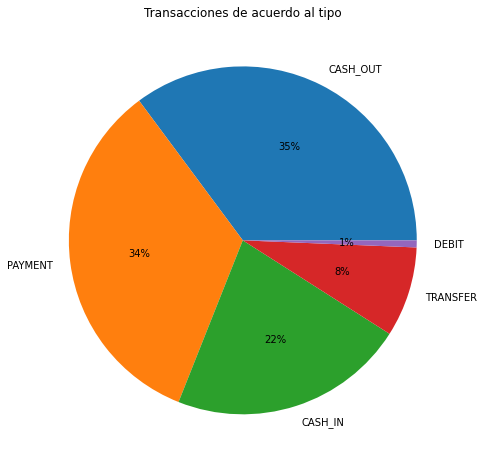

In [ ]:
plt.figure(figsize=(15,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index, autopct='%.0f%%')
plt.title("Transacciones de acuerdo al tipo")
plt.show()

Vamos a ver que tipo de relación tienen estos tipos de transacciones con la variable 'isFraud'

In [ ]:
#Ahora veremos la relacion entre la variable target (isFraud) y columnas categóricas (type, nameOrig, nameDest, step)
#Vamos a ver la media (del tipo en las transacciones fraudes)
#Veremos el total del tipo de transacciones en el dataset
#Y también la suma del tipo sólo en las transacciones fraudulentas.

df[['type', 'isFraud']].groupby(['type'], as_index=False).agg(['mean', 'count', 'sum'])

isFraud               
              mean    count   sum
type                             
CASH_IN   0.000000  1399284     0
CASH_OUT  0.001840  2237500  4116
DEBIT     0.000000    41432     0
PAYMENT   0.000000  2151495     0
TRANSFER  0.007688   532909  4097

Podemos ver que solo se registraron dos tipos de transacciones para la clase 'isFraud', PAGO EN EFECTIVO y TRANSFERENCIA. Esta información también nos ayudará a predecir los posibles fraudes.

In [41]:
#Para 'nameOrig' y 'nameDest' vamos a crear nuevas columnas: Primero usaremos su letra inicial= C (CLIENTE), y M (MERCANTIL)
#Para luego poder pasarlo a numéricos: (C=1) y (M=0).
#Esto será para favorecer el análisis y predicción del modelo
df['TypeOrigAccount'] = df['nameOrig'].str[0]
df['TypeDestAccount'] = df ['nameDest'].str[0]
df['TypeOrigAccount'].replace(['C', 'M'], [1, 0], inplace=True)
df['TypeDestAccount'].replace(['C', 'M'], [1, 0], inplace=True)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,TypeOrigAccount,TypeDestAccount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,1,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,1,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,1,1


In [ ]:
df[['TypeOrigAccount', 'isFraud']].groupby(['TypeOrigAccount'], as_index=False).agg(['mean', 'count', 'sum'])

isFraud               
                     mean    count   sum
TypeOrigAccount                         
1                0.001291  6362620  8213

In [ ]:
df[['TypeDestAccount', 'isFraud']].groupby(['TypeDestAccount'], as_index=False).agg(['mean', 'count', 'sum'])

isFraud               
                    mean    count   sum
TypeDestAccount                        
0                0.00000  2151495     0
1                0.00195  4211125  8213

Ahora podemos observar que las transacciones fraudulentas tienen su origen y su destino sólo en cuentas de Clientes (C=1)

In [42]:
#Step son los pasos contados en horas
#Vamos a pasar los step a formato 24 horas para ver la distribución horaria de la transacción fraudulenta y no fraudulenta
df['hour'] = df['step'] - 24 * (df['step'] // 24)

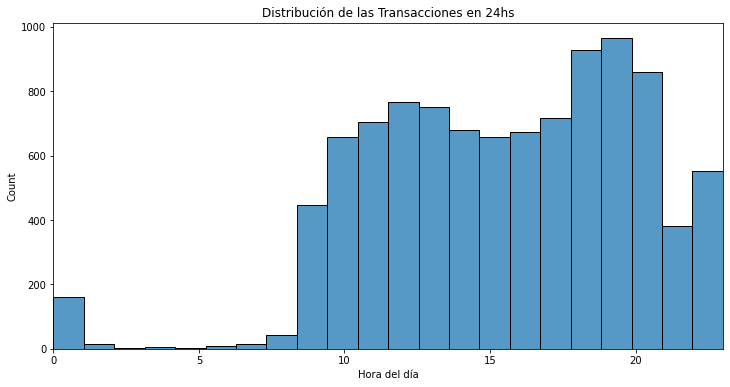

In [24]:
#Vamos a dibujar la distribución horaria de las transacciones.
plt.figure(figsize=(12, 6))
sns.histplot(data=df.sample(10000), x='hour', bins=22)
plt.title('Distribución de las Transacciones en 24hs')
plt.xlabel('Hora del día')
plt.xlim(0, 23);

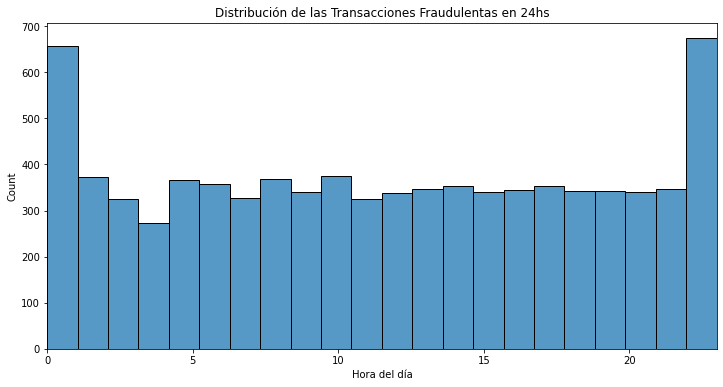

In [23]:
#Ahora solo las fraudulentas
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['isFraud'] == 1], x='hour', bins=22)
plt.title('Distribución de las Transacciones Fraudulentas en 24hs')
plt.xlabel('Hora del día')
plt.xlim(0, 23);

Podemos observar que las transacciones fraudulentas suceden con una frecuencia mayor entre las 23hs y 24hs. Y el total de transferencias tienen una frecuencia mayor entre 18 y 20 hs.

In [43]:
#Usaremos el método replace para el paso de datos categóricos a númericos en la columna type.

df['type'].replace(['CASH_OUT', 'TRANSFER', 'PAYMENT', 'CASH_IN', 'DEBIT'], [1, 2, 3, 4, 5], inplace=True)

#Eliminare las variables que no creo necesarias para la predicción.
datos_out = ['step', 'nameOrig', 'nameDest', 'isFlaggedFraud']
df.drop(datos_out, axis=1, inplace=True)

df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,TypeOrigAccount,TypeDestAccount,hour
0,3,9839.64,170136.00,160296.36,0.00,0.00,0,1,0,1
1,3,1864.28,21249.00,19384.72,0.00,0.00,0,1,0,1
2,2,181.00,181.00,0.00,0.00,0.00,1,1,1,1
3,1,181.00,181.00,0.00,21182.00,0.00,1,1,1,1
4,3,11668.14,41554.00,29885.86,0.00,0.00,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,1,339682.13,339682.13,0.00,0.00,339682.13,1,1,1,23
6362616,2,6311409.28,6311409.28,0.00,0.00,0.00,1,1,1,23
6362617,1,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,1,1,23
6362618,2,850002.52,850002.52,0.00,0.00,0.00,1,1,1,23





Preparamos el modelo de Random Forest

In [44]:
datos = df.copy()
datos.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,TypeOrigAccount,TypeDestAccount,hour
0,3,9839.64,170136.0,160296.36,0.0,0.0,0,1,0,1
1,3,1864.28,21249.0,19384.72,0.0,0.0,0,1,0,1
2,2,181.00,181.0,0.00,0.0,0.0,1,1,1,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,1,1
4,3,11668.14,41554.0,29885.86,0.0,0.0,0,1,0,1


In [45]:
#Dividimos el dataset con train_test_split
X = datos.drop(['isFraud'], axis=1)
Y = datos['isFraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Recordemos que no es necesario la estandarización de variables al momento de usar el algorritmo de Random Forest, ya que es bastante robusto y confiable a la hora de clasificar

In [51]:
#Entrenamos nuestro bosque aleatorio (Random Forest)
model = RandomForestClassifier().fit(X_train, Y_train)
#n_estimators=100, max_features=0.6 , max_depth=4, random_state=12
#model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

Accuracy=  1.00 
recall= 0.81



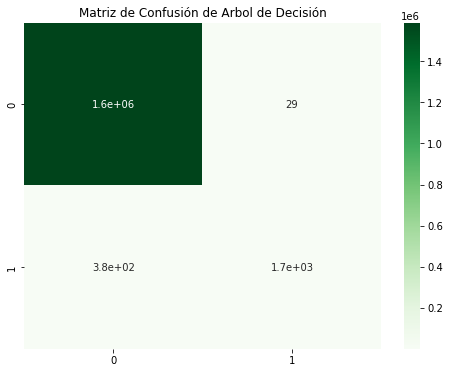

In [52]:
#Evaluación del modelo
print(f'Accuracy= {accuracy_score(Y_test, Y_pred): .2f} \nrecall= {recall_score(Y_test, Y_pred):.2f}\n')
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
plt.title('Matriz de Confusión de Arbol de Decisión')
sns.heatmap(cm, annot=True, cmap='Greens');

Nuestro algoritmo reconoce 

1 600 000 Verdaderos Negativos (0 : 'honestos') de un total de 1 600 29

1700 Verdaderos Positivos (1 : 'fraude') de un total de 2045

A pesar de que el Accuracy puede ser engañoso y pareciera que es un excelente modelo, podemos ver que nuestro Recall es de un %81, cosa que no esta tan mal comparandolo con el algoritmo previo.

In [54]:
X_test.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,TypeOrigAccount,TypeDestAccount,hour
3737323,4,330218.42,20866.00,351084.42,452419.57,122201.15,1,1,14
264914,3,11647.08,30370.00,18722.92,0.00,0.00,1,0,15
85647,4,152264.21,106589.00,258853.21,201303.01,49038.80,1,1,10
5899326,2,1551760.63,0.00,0.00,3198359.45,4750120.08,1,1,19
2544263,4,78172.30,2921331.58,2999503.88,415821.90,337649.60,1,1,14


In [70]:
#Probamos un dato nuevo
model.predict([[1, 43445.54,9453.45,345678.54,343454.54,454556.34,2,1,15],
               [1, 200.08, 5098.00, 10038.00, 343455.00, 0.00, 1, 1, 24],
               [1, 272.02, 10274.72, 22928.37, 5849.97, 4859.36, 1, 1, 00]])

array([0, 0, 0], dtype=int64)

In [76]:
#Probamos con datos nuevos:
nueva_data = {'type':[1],
              'amount':[181.00],
              'oldbalanceOrg':[181.00],
              'newbalanceOrig':[0.00],
              'oldbalanceDest':[21182.00],
              'newbalanceDest':[0.00],
              'TypeOrigAccount':[1],
              'TypeDestAccount':[1],
              'hour':[23]}
  
nueva_data1 = pd.DataFrame.from_dict(nueva_data)
print(model.predict(nueva_data1))

[0]


In [77]:
data = {'type':[1], 
        'amount':[43445.54],
        'oldbalanceOrg':[94453.45],
        'newbalanceOrig':[351345.93],
        'oldbalanceDest':[384583.83],
        'newbalanceDest':[38928.93],
        'TypeOrigAccount':[1],
        'TypeDestAccount':[1],
        'hour':[1]}
  
data1 = pd.DataFrame.from_dict(nueva_data)
print(model.predict(nueva_data1))

[0]
